# InSAR denoiser testing

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from PIL import Image
import rioxarray
import xarray as xr
import rasterio as rio

## define network and load model

In [2]:
class DnCNN_signal(nn.Module):
    """
    Neural network model for InSAR denoising adapted from Rouet-Leduc et al., 2021
    """
    def __init__(self):
        super().__init__()
        kernel_size=3
        padding=1
        features=64
        channels=2
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=1, dilation=1)
        
        # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=2, dilation=2)
        
        # Convolution 7
        self.cnn7 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=3, dilation=3)
        
        # Convolution 8
        self.cnn8 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=4, dilation=4)
        
        # Convolution 9
        self.cnn9 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 10
        self.cnn10 = nn.Conv2d(in_channels=384, out_channels=192, kernel_size=kernel_size, padding=padding)
        
        # Convolution 11
        self.cnn11 = nn.Conv2d(in_channels=192, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 12
        self.cnn12 = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=kernel_size, padding=padding)

    def forward(self, x, dem):                
        # Set 1
        out = F.elu(self.cnn1(torch.cat((x, dem), dim=1)), inplace=True) 
        
        # Set 2
        out = F.elu(self.cnn2(out), inplace=True) 
        
        # Set 3
        out = F.elu(self.cnn3(out), inplace=True)  
        
        # Set 4
        out = F.elu(self.cnn4(out), inplace=True) 
        
        # Set 5
        out_d5 = F.elu(self.cnn5(out), inplace=True)
        
        # Set 6
        out_d4 = F.elu(self.cnn6(out), inplace=True)
        
        # Set 7
        out_d3 = F.elu(self.cnn7(out), inplace=True)
        
        # Set 8
        out_d2 = F.elu(self.cnn8(out), inplace=True)
        
        # Set 9
        out_d1 = F.elu(self.cnn9(out), inplace=True)
        
        # Set 10
        out = F.elu(self.cnn10(torch.cat((out_d5, out_d4, out_d3, out_d2, out_d1, out), dim=1)), inplace=True)
        
        # Set 11
        out = F.elu(self.cnn11(out), inplace=True)
        
        # Set 9
        out = self.cnn12(out)
        
        return out

In [3]:
class DnCNN_noise(nn.Module):
    """
    Neural network model for InSAR denoising adapted from Rouet-Leduc et al., 2021
    """
    def __init__(self):
        super().__init__()
        kernel_size=3
        padding=1
        features=64
        channels=2
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
         # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 7
        self.cnn7 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 8
        self.cnn8 = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=kernel_size, padding=padding)

    def forward(self, x, dem):                
        # Set 1
        out = F.elu(self.cnn1(torch.cat((x, dem), dim=1)), inplace=True) 
        
        # Set 2
        out = F.elu(self.cnn2(out), inplace=True) 
        
        # Set 3
        out = F.elu(self.cnn3(out), inplace=True)  
        
        # Set 4
        out = F.elu(self.cnn4(out), inplace=True) 
        
        # Set 5
        out = F.elu(self.cnn5(out), inplace=True)
        
        # Set 6
        out = F.elu(self.cnn6(out), inplace=True)
        
        # Set 7
        out = F.elu(self.cnn7(out), inplace=True)

        # Set 8
        out = self.cnn8(out)
        
        return out

In [4]:
# load noise model
noise_model = DnCNN_noise()
noise_model.load_state_dict(torch.load('/Users/qbren/Desktop/taco/projects/atmospheric_correction/InSAR_denoising_CNN/noisemodelv1_600epochs'))

<All keys matched successfully>

In [5]:
# load signal model
#signal_model = DnCNN_signal()
#signal_model.load_state_dict(torch.load('/Users/qbren/Desktop/taco/projects/atmospheric_correction/InSAR_denoising_CNN/signal_modelv0_200_epochs'))

<All keys matched successfully>

# Load tifs

In [5]:
# functions to load interferogram tifs to xarray

def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds


def hyp3_to_xarray(hyp3_dir, file_type='unw_phase', interpolate_na=True):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        cwd = f'{hyp3_dir}/{idir}'
        os.chdir(cwd) #change to interferogram dir

        ext = f'{file_type}.tif' #end of filename for desired hyp3 product
        
        for fn in os.listdir(cwd): #select appropriate hyp3 product
            if fn[-len(ext):] == ext: 
                tif_fn = fn
        tif_path = f'{hyp3_dir}/{idir}/{tif_fn}'
        dates = f'{tif_fn[5:13]}_{tif_fn[21:29]}' #parse filename for interferogram dates
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)# need to interpolate na before passing NN
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    return ds 

In [6]:
# open ints and dems
hyp3_dir = '/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/test_data/asc_crop_sanjuans'

int_ds = hyp3_to_xarray(hyp3_dir)
int_ds = int_ds.rename({'band1':'unw_phase'})
int_ds = int_ds.rio.write_crs(32613)

dem_fn = 'S1AA_20160730T010937_20160823T010941_VVP024_INT40_G_ueF_2F0A/S1AA_20160730T010937_20160823T010941_VVP024_INT40_G_ueF_2F0A_dem.tif'
dem_src = rio.open(f'{hyp3_dir}/{dem_fn}')
dem_np = dem_src.read(1) 

In [8]:
# visualize arrays
#f, ax = plt.subplots(1,2,figsize=(15,7))
#ax[0].imshow(int_xarray.isel(dates=0).band1, cmap='RdBu')
#ax[0].set_title('interferogram')
#ax[1].imshow(dem_np)
#ax[1].set_title('DEM')
#plt.tight_layout()          

## Prepare for model run

In [7]:
# function to prepare arrays for model run
def arrays_to_tensor(int_array, dem_array, norm=True, dem_range=2):
    
    test_tensor = torch.Tensor(int_array.to_numpy()[0])
    dem_tensor = torch.Tensor(dem_array)
    
    if norm==True:
        #test_tensor = 2*(((test_tensor-(test_tensor.min()))/(test_tensor.max()-(test_tensor.min()))))-1
        dem_tensor = dem_range*(((dem_tensor-(dem_tensor.min()))/(dem_tensor.max()-(dem_tensor.min()))))-(dem_range/2)
    
    return test_tensor, dem_tensor


#functions to return to original values
def undo_norm(og_min, og_max, tensor):
    og_tensor = (((tensor+1)/2)*(og_max-og_min))+og_min
    
    return og_tensor

## noise model quick test

In [8]:
%%time
test, dem = arrays_to_tensor(int_ds.isel(dates=0).to_array(), dem_np, norm=True, dem_range=2)
with torch.no_grad():
    noise = noise_model(test[None, None, :, :], dem[None, None, :, :])

CPU times: total: 5min 39s
Wall time: 1min 10s


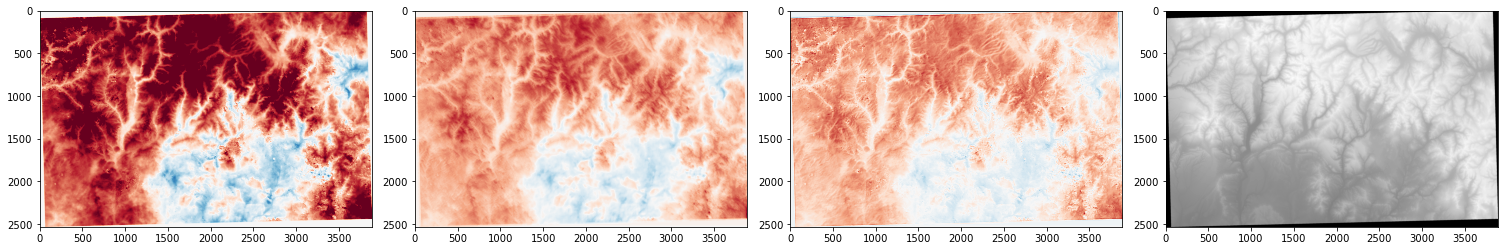

In [9]:
#plot full correction
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(test, cmap='RdBu', vmin=-10, vmax=10)
#ax[0].set_title('test image')
ax[1].imshow(noise.squeeze(), cmap='RdBu', vmin=-10, vmax=10)
#ax[1].set_title('predicted noise')
ax[2].imshow((test-noise.squeeze()), cmap='RdBu', vmin=-10, vmax=10)
#ax[2].set_title('predicted signal')
ax[3].imshow(dem, cmap='Greys_r')
#ax[3].set_title('DEM')
f.tight_layout()

In [ ]:
#plot zoomed in correction
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(test[800:1200, 1200:1600], cmap='RdBu', vmin=-15, vmax=15)
ax[0].set_title('test image')
ax[1].imshow(noise.squeeze()[800:1200, 1200:1600]*1.5, cmap='RdBu', vmin=-15, vmax=15)
ax[1].set_title('predicted noise (scaled)')
ax[2].imshow((test-noise.squeeze()*1.5)[800:1200, 1200:1600], cmap='RdBu', vmin=-15, vmax=15)
ax[2].set_title('predicted signal')
ax[3].imshow(dem[800:1200, 1200:1600], cmap='Greys_r')
ax[3].set_title('DEM')
plt.tight_layout()

In [ ]:
# visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_vars = [noise_model.cnn1, noise_model.cnn2, noise_model.cnn3, noise_model.cnn4,
            noise_model.cnn5, noise_model.cnn6, noise_model.cnn7, noise_model.cnn8,
            noise_model.cnn9, noise_model.cnn10, noise_model.cnn11]


def plot_feature_maps(cnn_vars, layer_num, test, dem):
    for i in range(layer_num):
        cnn_name = f'cnn{i+1}'
        cnn = cnn_vars[i]
        cnn.register_forward_hook(get_activation(cnn_name))
        output = noise_model(test, dem)

        act = activation[cnn_name].squeeze()
        act1 = act[0:15,:,:].sum(dim=0, keepdim=True).squeeze()
        act2 = act[16:31,:,:].sum(dim=0, keepdim=True).squeeze()
        act3 = act[32:47,:,:].sum(dim=0, keepdim=True).squeeze()
        act4 = act[48:63,:,:].sum(dim=0, keepdim=True).squeeze()

        fig, ax = plt.subplots(1, 5, figsize=(19,5))
        ax[0].imshow(test.squeeze(), cmap='RdBu')
        ax[0].set_title('original image')
        ax[1].imshow(act1)
        ax[1].set_title(f'{cnn_name} feature map')
        ax[2].imshow(act2)
        ax[2].set_title(f'{cnn_name} feature map')
        ax[3].imshow(act3)
        ax[3].set_title(f'{cnn_name} feature map')
        ax[4].imshow(act4)
        ax[4].set_title(f'{cnn_name} feature map')
        plt.tight_layout()

In [ ]:
plot_feature_maps(cnn_vars, 7, test[None, None, 500:1000, 500:1000], dem[None, None, 500:1000, 500:1000])

## noise model full run

In [10]:
noise_stack = np.empty_like(int_ds['unw_phase'][:].values)
signal_stack = np.empty_like(int_ds['unw_phase'][:].values)

for i in range(int_ds.sizes['dates']):
    print('working on', int_ds['dates'][i].values.item()) 
    test, dem = arrays_to_tensor(int_ds.isel(dates=i).to_array(), dem_np)
    with torch.no_grad():
        noise = noise_model(test[None, None, :, :], dem[None, None, :, :]) 
    noise_stack[i,:,:] = noise.detach().squeeze().numpy()
    signal_stack[i,:,:] = (test-noise.detach().squeeze()).numpy()

int_ds['pred_noise'] = (('dates', 'y', 'x'), noise_stack)
int_ds['pred_signal'] = (('dates', 'y', 'x'), signal_stack)

working on 20160730_20160823
working on 20160730_20160916
working on 20160823_20160916
working on 20160730_20170613
working on 20160730_20170625
working on 20160730_20170707
working on 20160823_20170613
working on 20160823_20170625
working on 20160823_20170707
working on 20160916_20170613
working on 20160916_20170625
working on 20160916_20170707
working on 20170613_20170625
working on 20170613_20170707
working on 20170613_20170731
working on 20170613_20170812
working on 20170625_20170707
working on 20170625_20170731
working on 20170625_20170812
working on 20170625_20170824
working on 20170707_20170731
working on 20170707_20170812
working on 20170707_20170824
working on 20170707_20170905
working on 20170731_20170812
working on 20170731_20170824
working on 20170731_20170905
working on 20170731_20170917
working on 20170731_20170929
working on 20170812_20170824
working on 20170812_20170905
working on 20170812_20170917
working on 20170812_20170929
working on 20170824_20170905
working on 201

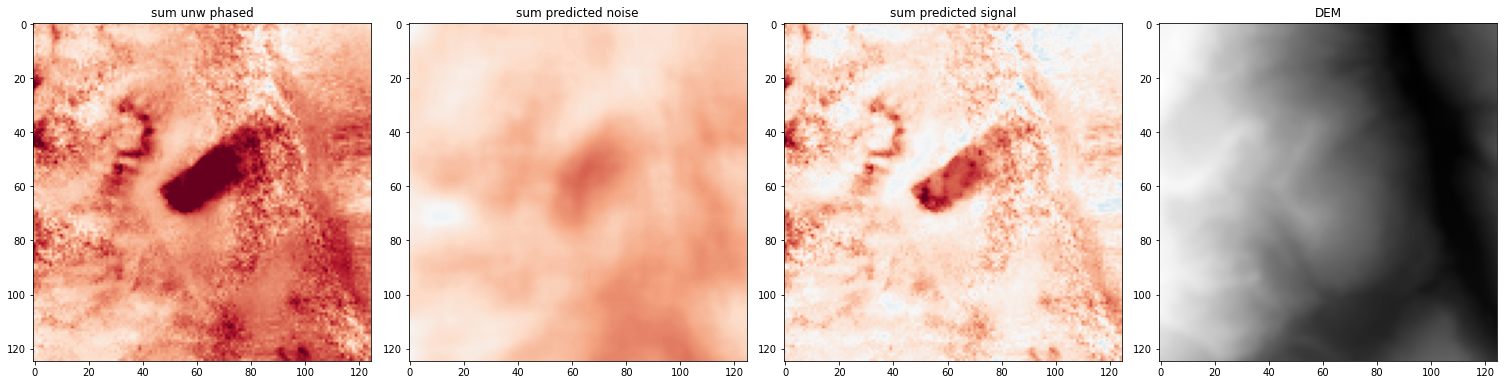

In [27]:
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(int_ds['unw_phase'][:,1125:1250, 1775:1900].sum(dim='dates'), cmap='RdBu_r', vmin=-250, vmax=250)
ax[0].set_title('sum unw phased')
ax[1].imshow(int_ds['pred_noise'][:,1125:1250, 1775:1900].sum(dim='dates'), cmap='RdBu_r', vmin=-250, vmax=250)
ax[1].set_title('sum predicted noise')
ax[2].imshow(int_ds['pred_signal'][:,1125:1250, 1775:1900].sum(dim='dates'), cmap='RdBu_r', vmin=-250, vmax=250)
ax[2].set_title('sum predicted signal')
ax[3].imshow(dem[1125:1250, 1775:1900], cmap='Greys_r')
ax[3].set_title('DEM')
plt.tight_layout()

In [33]:
# save to netcdf
#os.chdir('/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/test_xarray')
#int_ds.to_netcdf('/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/test_xarray/int_ds_noisemodelv1_600epochs.nc')

OverflowError: Python int too large to convert to C long

In [11]:
# save to tifs
def corrected_to_hyp3(ds, hyp3_dir):
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    
    for idir in dirs:
        cwd = f'{hyp3_dir}/{idir}'
        os.chdir(cwd) #change to interferogram dir
        fn = f'{idir}_unw_phase'
        print(f'working on {fn}')
        dates = f'{fn[5:13]}_{fn[21:29]}' #parse filename for interferogram dates
        
        ds['pred_signal'].sel(dates=dates).rio.to_raster(f'{fn}C.tif')
    
    print('done')

In [12]:
corrected_to_hyp3(int_ds, hyp3_dir)

working on S1AA_20160730T010937_20160823T010941_VVP024_INT40_G_ueF_2F0A_unw_phase
working on S1AA_20160730T010937_20160916T010939_VVP048_INT40_G_ueF_5207_unw_phase
working on S1AA_20160823T010941_20160916T010939_VVP024_INT40_G_ueF_9124_unw_phase
working on S1AB_20160730T010937_20170613T010855_VVP318_INT40_G_ueF_38B3_unw_phase
working on S1AB_20160730T010937_20170625T010856_VVP330_INT40_G_ueF_7F7A_unw_phase
working on S1AB_20160730T010937_20170707T010857_VVP342_INT40_G_ueF_61B4_unw_phase
working on S1AB_20160823T010941_20170613T010855_VVP294_INT40_G_ueF_1A6F_unw_phase
working on S1AB_20160823T010941_20170625T010856_VVP306_INT40_G_ueF_32EA_unw_phase
working on S1AB_20160823T010941_20170707T010857_VVP318_INT40_G_ueF_225F_unw_phase
working on S1AB_20160916T010939_20170613T010855_VVP270_INT40_G_ueF_C133_unw_phase
working on S1AB_20160916T010939_20170625T010856_VVP282_INT40_G_ueF_3286_unw_phase
working on S1AB_20160916T010939_20170707T010857_VVP294_INT40_G_ueF_40D4_unw_phase
working on S1BB_

## signal model quick test

In [ ]:
test, dem = arrays_to_tensor(int_ds.isel(dates=204).to_array(), dem_np, norm=True, dem_range=2)
with torch.no_grad():
    noise = noise_model(test[None, None, :, :], dem[None, None, :, :])
f, ax = plt.subplots(1, 4, figsize=(15, 8))
ax[0].imshow(test, cmap='RdBu', vmin=-10, vmax=10)
ax[0].set_title('test image')
ax[1].imshow((test-signal.detach().squeeze()), cmap='RdBu', vmin=-10, vmax=10)
ax[1].set_title('predicted noise')
ax[2].imshow(signal.detach().squeeze(), cmap='RdBu', vmin=-10, vmax=10)
ax[2].set_title('predicted signal')
ax[3].imshow(dem, cmap='Greys_r')
ax[3].set_title('dem')
plt.tight_layout()

In [ ]:
# visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_vars = [signal_model.cnn1, signal_model.cnn2, signal_model.cnn3, signal_model.cnn4,
            signal_model.cnn5, signal_model.cnn6, signal_model.cnn7, signal_model.cnn8,
            signal_model.cnn9, signal_model.cnn10, signal_model.cnn11]


def plot_feature_maps(cnn_vars, layer_num, test, dem):
    for i in range(layer_num):
        cnn_name = f'cnn{i+1}'
        cnn = cnn_vars[i]
        cnn.register_forward_hook(get_activation(cnn_name))
        output = signal_model(test, dem)

        act = activation[cnn_name].squeeze()
        act1 = act[0:15,:,:].sum(dim=0, keepdim=True).squeeze()
        act2 = act[16:31,:,:].sum(dim=0, keepdim=True).squeeze()
        act3 = act[32:47,:,:].sum(dim=0, keepdim=True).squeeze()
        act4 = act[48:63,:,:].sum(dim=0, keepdim=True).squeeze()

        fig, ax = plt.subplots(1, 5, figsize=(19,5))
        ax[0].imshow(test.squeeze(), cmap='RdBu')
        ax[0].set_title('original image')
        ax[1].imshow(act1)
        ax[1].set_title(f'{cnn_name} feature map')
        ax[2].imshow(act2)
        ax[2].set_title(f'{cnn_name} feature map')
        ax[3].imshow(act3)
        ax[3].set_title(f'{cnn_name} feature map')
        ax[4].imshow(act4)
        ax[4].set_title(f'{cnn_name} feature map')
        plt.tight_layout()

In [ ]:
#plot_feature_maps(cnn_vars, 7, test[None, None, 500:1000, 500:1000], dem[None, None, 500:1000, 500:1000])

## signal model full run

In [ ]:
noise_stack = np.empty_like(int_ds['unw_phase'][:].values)
signal_stack = np.empty_like(int_ds['unw_phase'][:].values)

for i in range(int_ds.sizes['dates']):
    print('working on', int_xarray['dates'][i].values.item()) 
    test, dem = arrays_to_tensor(int_ds.isel(dates=i).to_array(), dem_np)
    with torch.no_grad():
        signal = signal_model(test[None, None, :, :], dem[None, None, :, :]) 
    signal_stack[i,:,:] = signal.detach().squeeze().numpy()
    noise_stack[i,:,:] = (test-signal.detach().squeeze()).numpy()

int_xarray['pred_noise'] = (('dates', 'y', 'x'), noise_stack)
int_xarray['pred_signal'] = (('dates', 'y', 'x'), signal_stack)

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(int_ds['unw_phase'].median(dim='dates'), cmap='RdBu', vmin=-2, vmax=2)
ax[0].set_title('median unw phased')
ax[1].imshow(int_ds['pred_noise'].median(dim='dates'), cmap='RdBu', vmin=-2, vmax=2)
ax[1].set_title('median predicted noise')
ax[2].imshow(int_ds['pred_signal'].median(dim='dates'), cmap='RdBu', vmin=-2, vmax=2)
ax[2].set_title('median predicted signal')
ax[3].imshow(dem, cmap='Greys_r')
ax[3].set_title('DEM')
plt.tight_layout()

In [ ]:
#corrected_to_hyp3(int_ds, hyp3_dir)